In [1]:
!pip install fuzzywuzzy
!pip install fuzzymatcher

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

# Read in Turnstile Files: April - June 2018, 2019

In [3]:
#import and combine all turnstile files
import glob
import pandas as pd
extension = 'txt'
all_filenames = [i for i in glob.glob('turnstile*.{}'.format(extension))]
print(all_filenames)

#combine all files in the list
total_df = pd.concat([pd.read_csv(f) for f in all_filenames ])

#fix column names by getting rid of white spaces
total_df.columns = [word.strip() for word in total_df.columns]
total_df.columns


#make 'STATION' column match the new df we are about to feed in
total_df['STATION'] = total_df['STATION'].str.lower()
total_df.rename(columns = {'STATION': 'Station Name'}, inplace = True)


['turnstile_180407.txt', 'turnstile_180414.txt', 'turnstile_180421.txt', 'turnstile_180428.txt', 'turnstile_180505.txt', 'turnstile_180512.txt', 'turnstile_180519.txt', 'turnstile_180526.txt', 'turnstile_180602.txt', 'turnstile_180609.txt', 'turnstile_180616.txt', 'turnstile_180623.txt', 'turnstile_180630.txt', 'turnstile_190406 copy.txt', 'turnstile_190413 copy.txt', 'turnstile_190420 copy.txt', 'turnstile_190427 copy.txt', 'turnstile_190504 copy.txt', 'turnstile_190511 copy.txt', 'turnstile_190518 copy.txt', 'turnstile_190525 copy.txt', 'turnstile_190601 copy.txt', 'turnstile_190608 copy.txt', 'turnstile_190615 copy.txt', 'turnstile_190622 copy.txt', 'turnstile_190629 copy.txt']


In [4]:
#since we merged so many dfs there are now multiple of the same values in the index. we must reset
total_df.reset_index(inplace = True)

# Read in Subway Tract ID Data

In [5]:
#Get subway tract IDs and merge them with overall csv
subway_tracts = pd.read_pickle('nyc_subway_final.pkl')
subway_tracts['Stop Name'] = subway_tracts['Stop Name'].str.lower()
subway_tracts.rename(columns = {'Stop Name': 'Station Name'}, inplace = True)
subway_tracts.reset_index(inplace = True)
total_df.shape


(5225091, 12)

In [6]:


unique_stations = pd.DataFrame(total_df['Station Name'].unique(), columns = ['Station Name'])


# Merging DataFrames

Since we want to merge on "Station Names" and the 2 dataframes have mismatched values on these columns, we have to fuzzy match

In [7]:

#if we can create a dictionary of station name values to station names in the subway tracts, then we can map.
#1. create  table of only the unique station names
#2. compare
#3. take only values with matches above a certain threshold
#4. create dictionary and map matches from "subway_tracts" to total_df
import fuzzymatcher
from fuzzymatcher import link_table, fuzzy_left_join

# Columns to match on from df_left
left_on = ['Station Name']

# Columns to match on from df_right
right_on = ['Station Name']

# The link table potentially contains several matches for each record

#filter until we get candidates for name changes
matches = fuzzymatcher.link_table(unique_stations, subway_tracts, left_on, right_on)
good_matches = matches[matches['match_score']>0.05]
changeable_matches = (good_matches[good_matches['Station Name_left'] != good_matches['Station Name_right']]).reset_index()
display(changeable_matches)
#res = dict(zip(test_keys, test_values)) 

matches_dictionary = dict(zip(changeable_matches['Station Name_left'], changeable_matches['Station Name_right']))
display(matches_dictionary)
print('done')

,index,__id_left,__id_right,match_score,match_rank,Station Name_left,Station Name_right
0,7,2_left,33_right,0.279079,1,57 st-7 av,57 st - 7 av
1,9,4_left,152_right,0.434996,1,times sq-42 st,times sq - 42 st
2,10,4_left,154_right,0.434996,2,times sq-42 st,times sq - 42 st
3,11,5_left,13_right,0.434996,1,34 st-herald sq,34 st - herald sq
4,12,5_left,14_right,0.434996,2,34 st-herald sq,34 st - herald sq
...,...,...,...,...,...,...,...
108,1547,367_left,375_right,0.250569,1,eastchster/dyre,eastchester - dyre av
109,1548,368_left,449_right,0.346976,1,st. george,st george
110,1554,373_left,124_right,0.170551,1,knickerbocker,knickerbocker av
111,1569,377_left,177_right,0.215688,1,163 st-amsterdm,163 st - amsterdam av


{'57 st-7 av': '57 st - 7 av',
 'times sq-42 st': 'times sq - 42 st',
 '34 st-herald sq': '34 st - herald sq',
 '14 st-union sq': '14 st - union sq',
 '8 st-nyu': '8 st - nyu',
 'city hall': 'brooklyn bridge - city hall',
 'delancey/essex': 'essex st',
 'prospect park': '15 st - prospect park',
 'beverley road': 'beverley rd',
 'jay st-metrotec': 'jay st - metrotech',
 'union st': '14 st - union sq',
 '25 st': 'beach 25 st',
 '36 st': 'beach 36 st',
 'bay ridge-95 st': 'bay ridge - 95 st',
 '50 st': 'bay 50 st',
 'w 8 st-aquarium': 'w 8 st - ny aquarium',
 'myrtle-wyckoff': 'myrtle - wyckoff avs',
 'bushwick av': 'bushwick av - aberdeen st',
 'atlantic av': 'atlantic av - barclays ctr',
 'sutter av': 'sutter av - rutland rd',
 'new lots': 'new lots av',
 'canarsie-rockaw': 'canarsie - rockaway pkwy',
 'howard bch jfk': 'howard beach - jfk airport',
 '85 st-forest pk': '85 st - forest pkwy',
 'seneca ave': 'seneca av',
 'forest ave': 'forest av',
 'inwood-207 st': 'inwood - 207 st',
 'c

done


In [8]:
total_df.at[700, 'Station Name']
len(matches_dictionary)

94

In [9]:
%%time

# def match_station_names(series):
#     for i,value in enumerate(series):
#         if series.iloc[i] in matches_dictionary.keys():
#             series.iloc[i] = matches_dictionary[series.iloc[i]]
#         return series.iloc[i]

for i in range(0, len(total_df['Station Name'])):
    if total_df.at[i, 'Station Name'] in matches_dictionary.keys():
        total_df.at[i, 'Station Name'] = matches_dictionary[total_df.at[i, 'Station Name']]

CPU times: user 2min 46s, sys: 778 ms, total: 2min 47s
Wall time: 2min 53s


In [10]:
total_df

,index,C/A,UNIT,SCP,Station Name,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,0,A002,R051,02-00-00,59 st,NQR456W,BMT,03/31/2018,00:00:00,REGULAR,6566463,2224050
1,1,A002,R051,02-00-00,59 st,NQR456W,BMT,03/31/2018,04:00:00,REGULAR,6566470,2224053
2,2,A002,R051,02-00-00,59 st,NQR456W,BMT,03/31/2018,08:00:00,REGULAR,6566470,2224053
3,3,A002,R051,02-00-00,59 st,NQR456W,BMT,03/31/2018,12:00:00,REGULAR,6566470,2224055
4,4,A002,R051,02-00-00,59 st,NQR456W,BMT,03/31/2018,16:00:00,REGULAR,6566470,2224055
...,...,...,...,...,...,...,...,...,...,...,...,...
5225086,205958,TRAM2,R469,00-05-01,rit-roosevelt,R,RIT,06/28/2019,05:00:00,REGULAR,5554,379
5225087,205959,TRAM2,R469,00-05-01,rit-roosevelt,R,RIT,06/28/2019,09:00:00,REGULAR,5554,379
5225088,205960,TRAM2,R469,00-05-01,rit-roosevelt,R,RIT,06/28/2019,13:00:00,REGULAR,5554,379
5225089,205961,TRAM2,R469,00-05-01,rit-roosevelt,R,RIT,06/28/2019,17:00:00,REGULAR,5554,379


In [11]:
merged_df = total_df.merge(subway_tracts, how = 'left', on = 'Station Name')

In [12]:
#check to see how many null values we have for tract ID

display(merged_df.isnull().sum())
#from the initial combine, we are still missing tract IDs from 5.6 Mill / ~7.8Mill values. 
#There might be a mismatch between station names in the subway file vs the turnstile file
merged_df

index_x                    0
C/A                        0
UNIT                       0
SCP                        0
Station Name               0
LINENAME                   0
DIVISION                   0
DATE                       0
TIME                       0
DESC                       0
ENTRIES                    0
EXITS                      0
index_y               972442
Division              972442
Borough               972442
Station_Division      972442
Borough2              972442
GTFS Latitude         972442
GTFS Longitude        972442
census_tract_id       972442
HHIncomePct_score    1504035
dtype: int64

,index_x,C/A,UNIT,SCP,Station Name,LINENAME,DIVISION,DATE,TIME,DESC,...,EXITS,index_y,Division,Borough,Station_Division,Borough2,GTFS Latitude,GTFS Longitude,census_tract_id,HHIncomePct_score
0,0,A002,R051,02-00-00,59 st,NQR456W,BMT,03/31/2018,00:00:00,REGULAR,...,2224050,34.0,BMT,Bk,59 St_BMT,Brooklyn,40.641362,-74.017881,36047007400,2.0
1,0,A002,R051,02-00-00,59 st,NQR456W,BMT,03/31/2018,00:00:00,REGULAR,...,2224050,127.0,IRT,M,59 St_IRT,Manhattan,40.762526,-73.967967,36061011402,10.0
2,1,A002,R051,02-00-00,59 st,NQR456W,BMT,03/31/2018,04:00:00,REGULAR,...,2224053,34.0,BMT,Bk,59 St_BMT,Brooklyn,40.641362,-74.017881,36047007400,2.0
3,1,A002,R051,02-00-00,59 st,NQR456W,BMT,03/31/2018,04:00:00,REGULAR,...,2224053,127.0,IRT,M,59 St_IRT,Manhattan,40.762526,-73.967967,36061011402,10.0
4,2,A002,R051,02-00-00,59 st,NQR456W,BMT,03/31/2018,08:00:00,REGULAR,...,2224053,34.0,BMT,Bk,59 St_BMT,Brooklyn,40.641362,-74.017881,36047007400,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7536641,205958,TRAM2,R469,00-05-01,rit-roosevelt,R,RIT,06/28/2019,05:00:00,REGULAR,...,379,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7536642,205959,TRAM2,R469,00-05-01,rit-roosevelt,R,RIT,06/28/2019,09:00:00,REGULAR,...,379,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7536643,205960,TRAM2,R469,00-05-01,rit-roosevelt,R,RIT,06/28/2019,13:00:00,REGULAR,...,379,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7536644,205961,TRAM2,R469,00-05-01,rit-roosevelt,R,RIT,06/28/2019,17:00:00,REGULAR,...,379,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
merged_df.to_pickle('turnstile_borough_merged.pkl')

# Change Date and Time Columns to Date Time Format

In [14]:
total_df['date_time'] = pd.to_datetime(total_df['DATE'] +' ' + total_df['TIME'], format = '%m/%d/%Y %H:%M:%S')
total_df['DATE']=pd.to_datetime(total_df['DATE'])


# Now Investigate / Create "Traffic" Column

In [15]:
#Are there duplicates?
turnstile_df = total_df.groupby(['C/A', 'UNIT', 'SCP', 'Station Name','DATE', 'date_time'])['ENTRIES', 'EXITS'].first().reset_index()

duplicates_df = turnstile_df.groupby(['C/A', 'UNIT', 'SCP', 'Station Name', 'DATE', 'date_time']).ENTRIES.count().reset_index()
duplicates_df.sort_values(by = ['ENTRIES'], ascending = False)
#No Duplicates because we didn't include the 'DESC' column the first time


/Users/plam1122/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,C/A,UNIT,SCP,Station Name,DATE,date_time,ENTRIES
0,A002,R051,02-00-00,59 st,2018-03-31,2018-03-31 00:00:00,1
3483350,R142,R293,01-06-00,34 st - penn station,2019-04-09,2019-04-09 14:00:00,1
3483357,R142,R293,01-06-00,34 st - penn station,2019-04-10,2019-04-10 18:00:00,1
3483356,R142,R293,01-06-00,34 st - penn station,2019-04-10,2019-04-10 14:00:00,1
3483355,R142,R293,01-06-00,34 st - penn station,2019-04-10,2019-04-10 10:00:00,1
...,...,...,...,...,...,...,...
1741676,N141,R356,00-00-00,ozone pk leffrt,2018-06-08,2018-06-08 00:00:00,1
1741675,N141,R356,00-00-00,ozone pk leffrt,2018-06-07,2018-06-07 20:00:00,1
1741674,N141,R356,00-00-00,ozone pk leffrt,2018-06-07,2018-06-07 16:00:00,1
1741673,N141,R356,00-00-00,ozone pk leffrt,2018-06-07,2018-06-07 12:00:00,1


In [16]:
turnstile_df = turnstile_df.sort_values(by = 'date_time')


In [17]:
turnstile_df = turnstile_df.groupby(['C/A', 'UNIT', 'SCP', 'Station Name', 'DATE'])['ENTRIES', 'EXITS'].first().reset_index()

turnstile_df[['Prev_Date', 'Prev_Entry']] = (turnstile_df.groupby(['C/A', 'UNIT', 'SCP', 'Station Name'])
                                            ['DATE','ENTRIES'].apply(lambda x: x.shift(1)))

turnstile_df['Prev_Exit'] = (turnstile_df.groupby(['C/A', 'UNIT', 'SCP', 'Station Name'])['EXITS'].apply(lambda x: x.shift(1)))
turnstile_df

/Users/plam1122/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
/Users/plam1122/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


,C/A,UNIT,SCP,Station Name,DATE,ENTRIES,EXITS,Prev_Date,Prev_Entry,Prev_Exit
0,A002,R051,02-00-00,59 st,2018-03-31,6566463,2224050,NaT,NaN,NaN
1,A002,R051,02-00-00,59 st,2018-04-01,6566470,2224055,2018-03-31,6566463.0,2224050.0
2,A002,R051,02-00-00,59 st,2018-04-02,6566470,2224055,2018-04-01,6566470.0,2224055.0
3,A002,R051,02-00-00,59 st,2018-04-03,6567630,2224496,2018-04-02,6566470.0,2224055.0
4,A002,R051,02-00-00,59 st,2018-04-04,6568921,2225039,2018-04-03,6567630.0,2224496.0
...,...,...,...,...,...,...,...,...,...,...
868035,TRAM2,R469,00-05-01,rit-roosevelt,2019-06-24,5554,379,2019-06-23,5554.0,379.0
868036,TRAM2,R469,00-05-01,rit-roosevelt,2019-06-25,5554,379,2019-06-24,5554.0,379.0
868037,TRAM2,R469,00-05-01,rit-roosevelt,2019-06-26,5554,379,2019-06-25,5554.0,379.0
868038,TRAM2,R469,00-05-01,rit-roosevelt,2019-06-27,5554,379,2019-06-26,5554.0,379.0


In [18]:
turnstile_df.dropna(subset = ['Prev_Date'], axis = 0, inplace = True)
def daily_entries(row):
    
    count = row['ENTRIES'] - row['Prev_Entry']
    if count < 0:
        count = -count
    if count > 86400:
        return 0
    return count

def daily_exits(row):
    count = row['EXITS'] - row['Prev_Exit']
    if count < 0:
        count = -count
    if count > 86400:
        return 0
    return count
turnstile_df['daily_entries'] = turnstile_df.apply(daily_entries, axis = 1)
turnstile_df['daily_exits'] = turnstile_df.apply(daily_exits, axis = 1)

#total_df.to_pickle('total_df.pkl')
turnstile_df.to_pickle('turnstile_df.pkl')

turnstile_df

,C/A,UNIT,SCP,Station Name,DATE,ENTRIES,EXITS,Prev_Date,Prev_Entry,Prev_Exit,daily_entries,daily_exits
1,A002,R051,02-00-00,59 st,2018-04-01,6566470,2224055,2018-03-31,6566463.0,2224050.0,7.0,5.0
2,A002,R051,02-00-00,59 st,2018-04-02,6566470,2224055,2018-04-01,6566470.0,2224055.0,0.0,0.0
3,A002,R051,02-00-00,59 st,2018-04-03,6567630,2224496,2018-04-02,6566470.0,2224055.0,1160.0,441.0
4,A002,R051,02-00-00,59 st,2018-04-04,6568921,2225039,2018-04-03,6567630.0,2224496.0,1291.0,543.0
5,A002,R051,02-00-00,59 st,2018-04-05,6570307,2225512,2018-04-04,6568921.0,2225039.0,1386.0,473.0
...,...,...,...,...,...,...,...,...,...,...,...,...
868035,TRAM2,R469,00-05-01,rit-roosevelt,2019-06-24,5554,379,2019-06-23,5554.0,379.0,0.0,0.0
868036,TRAM2,R469,00-05-01,rit-roosevelt,2019-06-25,5554,379,2019-06-24,5554.0,379.0,0.0,0.0
868037,TRAM2,R469,00-05-01,rit-roosevelt,2019-06-26,5554,379,2019-06-25,5554.0,379.0,0.0,0.0
868038,TRAM2,R469,00-05-01,rit-roosevelt,2019-06-27,5554,379,2019-06-26,5554.0,379.0,0.0,0.0


# See Which Stations Have the Most Traffic

In [19]:
#create the column "total traffic"

#df['variance'] = df.loc[:,['budget','actual']].sum(axis=1)
turnstile_df['total_traffic'] = turnstile_df['daily_entries'] + turnstile_df['daily_exits']
top_stations = turnstile_df.groupby(['Station Name'])['total_traffic'].sum()

In [20]:
import matplotlib.pyplot as plt
top_stations = top_stations.sort_values(ascending = False)

Text(0.5, 1.0, 'Total Traffic: Apr-Jun, 2018 - 2020')

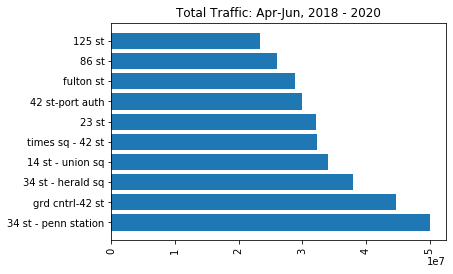

In [21]:
plt.barh(top_stations.head(10).index, top_stations.head(10))
plt.xticks(rotation = 90)
plt.title('Total Traffic: Apr-Jun, 2018 - 2020')

# See Which Days Have the Most Traffic

DAY
Monday        729.0
Tuesday      1759.0
Wednesday    1949.0
Thursday     1977.0
Friday       1976.0
Saturday     1863.0
Sunday        972.0
Name: total_traffic, dtype: float64
Max:  DAY
Thursday    1977.0
Name: total_traffic, dtype: float64


Monday       124122
Tuesday      124077
Sunday       124072
Friday       123889
Wednesday    123880
Thursday     123797
Saturday     119242
Name: DAY, dtype: int64

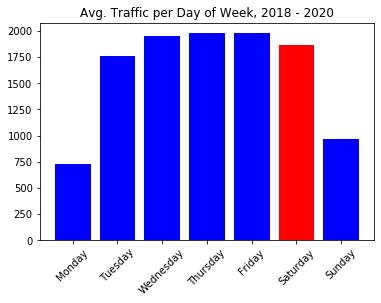

In [22]:
turnstile_df['DAY'] = turnstile_df['DATE'].dt.day_name()
turnstile_df['WEEK'] = turnstile_df['DATE'].dt.week


cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

DOW_table = turnstile_df.groupby(['DAY'])['total_traffic'].median().reindex(cats)

print(DOW_table)
print("Max: ", DOW_table[DOW_table == DOW_table.max()])


colors = ['b']*len(DOW_table)
colors[5] = 'r'
plt.bar(DOW_table.index, DOW_table, color = colors)

plt.xticks(rotation = 45)
plt.title('Avg. Traffic per Day of Week, 2018 - 2020')

turnstile_df['DAY'].value_counts()

Max:  WEEK
13    6166.386317
Name: total_traffic, dtype: float64


Text(0.5, 1.0, 'Avg Traffic per Each Week, 2018 - 2020')

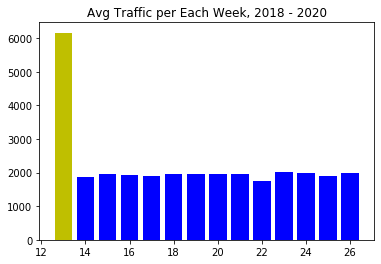

In [23]:
WEEK_table = turnstile_df.groupby(['WEEK'])['total_traffic'].mean()
print("Max: ", WEEK_table[WEEK_table == WEEK_table.max()])



colors = ["b"] * (len(WEEK_table))
colors[0] = "y"

plt.bar(WEEK_table.index, WEEK_table, color = colors)
plt.title('Avg Traffic per Each Week, 2018 - 2020')

# Create Dataframe with Only Stations in the Top 20 in Traffic

In [24]:
top_stations = [station for station in top_turnstiles.head(20).index]

top_20_total = combined_turnstile_csv[(combined_turnstile_csv['Station Name'].isin(top_stations))]
#(combined_turnstile_csv['Station Name'].isin(top_stations))

#df_new[df_new['l_ext'].isin([31, 22, 30, 25, 64])]

NameError: name 'top_turnstiles' is not defined

In [ ]:
#convert to DateTime, add column for DOW

top_20_total['DATE'] = pd.to_datetime(top_20_total['DATE'])
top_20_total['DAY'] = top_20_total['DATE'].dt.day_name()
top_20_total['WEEK'] = top_20_total['DATE'].dt.week
#pd.to_datetime(df['DataFrame Column'], format=specify your format)

top_20_total

In [ ]:
DOW_table = top_20_total.groupby(['DAY'])['total_traffic'].mean()
print("Max: ", DOW_table[DOW_table == DOW_table.max()])

colors = ['b']*len(DOW_table)
colors[5] = 'y'
plt.bar(DOW_table.index, DOW_table, color = colors)

plt.xticks(rotation = 45)
plt.title('Avg. Traffic per Day of Week, 2018 - 2020')

In [ ]:
WEEK_table = top_20_total.groupby(['WEEK'])['total_traffic'].mean()
print("Max: ", WEEK_table[WEEK_table == WEEK_table.max()])



colors = ["b"] * (len(WEEK_table))
colors[11] = "y"

plt.bar(WEEK_table.index, WEEK_table, color = colors)
plt.title('Avg Traffic per Each Week, 2018 - 2020')